# Import Functions

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import h5py

# Set File Paths

In [2]:
# Folder containing all data and figures for the paper
paperfolder = 'C:\\Users\\janef\\OneDrive - Northwestern University\\Documents - Backman Lab - Shared Folders\\Lab Paper Drafts\\OCSC Chromatin Transcription Paper 2024'
# Folder containing all raw PWS data as image cubes
pwsfolder = paperfolder+'\\Data\\PWS Raw Image Cubes'
# Folder containing the LUT generated in MATLAB to convert sigma to D
conversionfolder = paperfolder+'\\Codes\\Sigma to D'
# Folder location for saving images
savefolder = paperfolder+'\\Figures\\PWS D and BF Images\\New Colormap'

# If the folder for saving images does not exist, the code will create it
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

# Set Figure Parameters

In [3]:
mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["axes.edgecolor"] = 'k'
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams['errorbar.capsize'] = 2.5
mpl.rcParams['legend.frameon'] = False

# Create Custom Colormap for PWS Images

In [4]:
# Define a custom colormap that ranges from black to red
# Only use the first half of the red colormap (from 0 to 0.5)
cmap_colors = [(0, 0, 0), (1, 0, 0)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmap_colors, N=256)

# Define a custom colormap that ranges from black to gray
graycmap = mpl.colormaps.get_cmap('gray')
# Only use the first quarter of the gray colormap (from 0 to 0.25)
newgray = mpl.colors.ListedColormap(graycmap(np.linspace(0, 0, 256)))

# Set the minimum and maximum D values for images
minv = 1.5
maxv = 3

# Create the color vector for the colorbars using the minimum and maximum D values
norm = mpl.colors.Normalize(vmin=minv, vmax=maxv)

# Output Horizontal D Colorbar

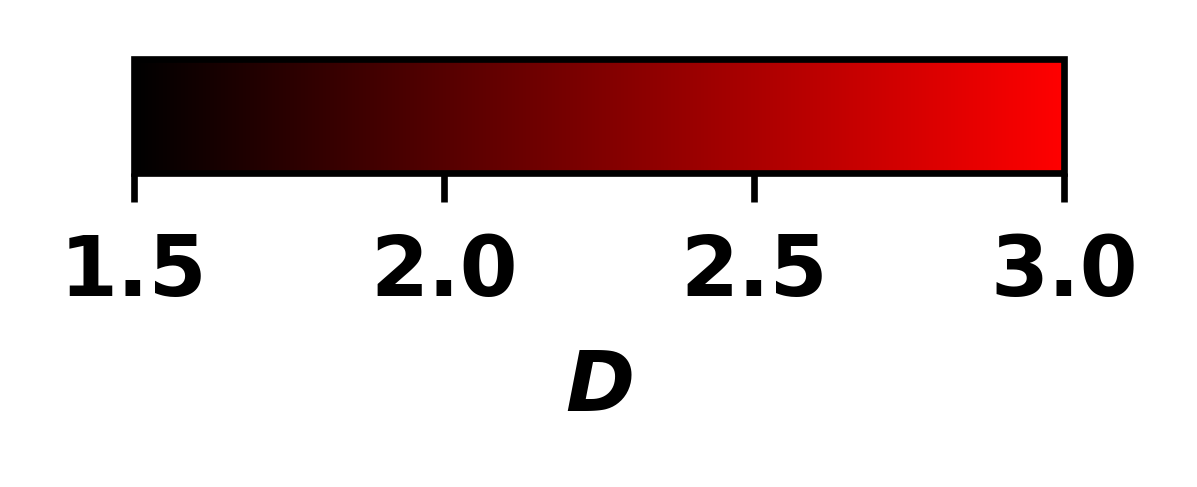

In [5]:
# Create and display a horizontal colorbar for the red D pseudocolor
fig, ax = plt.subplots(figsize=(2, 0.5))
fig.subplots_adjust(bottom=0.5)
cb = mpl.colorbar.ColorbarBase(ax,cmap=cmap,norm=norm,orientation='horizontal')
cb.ax.set_xlabel(r'$D$')
# Save the colorbar to the parent folder
plt.savefig(savefolder+'\\..\\PWS D Colorbar Horizontal.tif',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

# Output Vertical D Scalebar

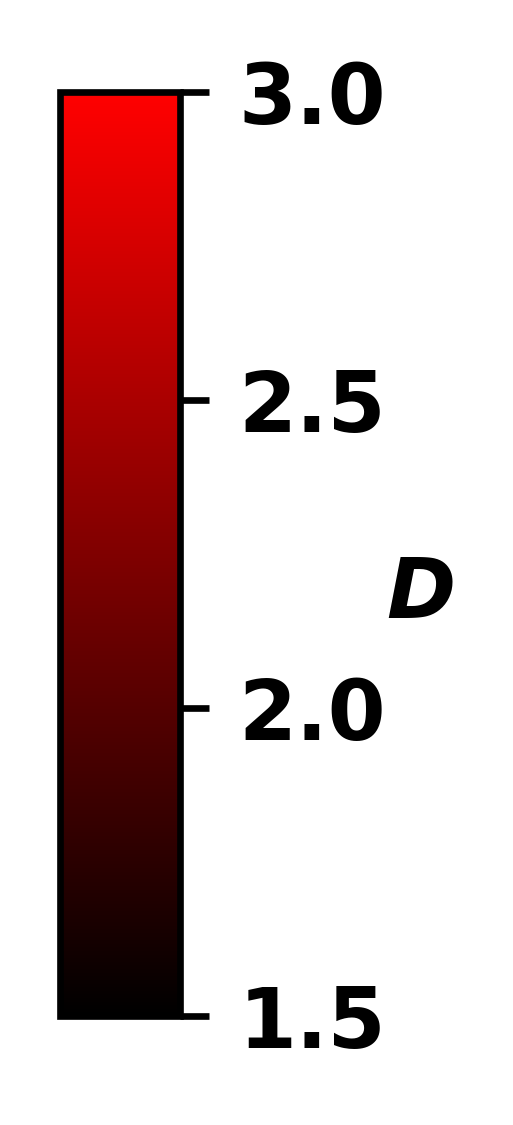

In [6]:
# Create and display a horizontal colorbar for the red D pseudocolor
fig, ax = plt.subplots(figsize=(0.5, 2))
fig.subplots_adjust(left=0.5)
cb = mpl.colorbar.ColorbarBase(ax,cmap=cmap,norm=norm,orientation='vertical')
cb.ax.set_ylabel(r'$D$',rotation=0)
# Save the colorbar to the parent folder
plt.savefig(savefolder+'\\..\\PWS D Colorbar Vertical.tif',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

# Create Sigma to D Conversion Function from LUT

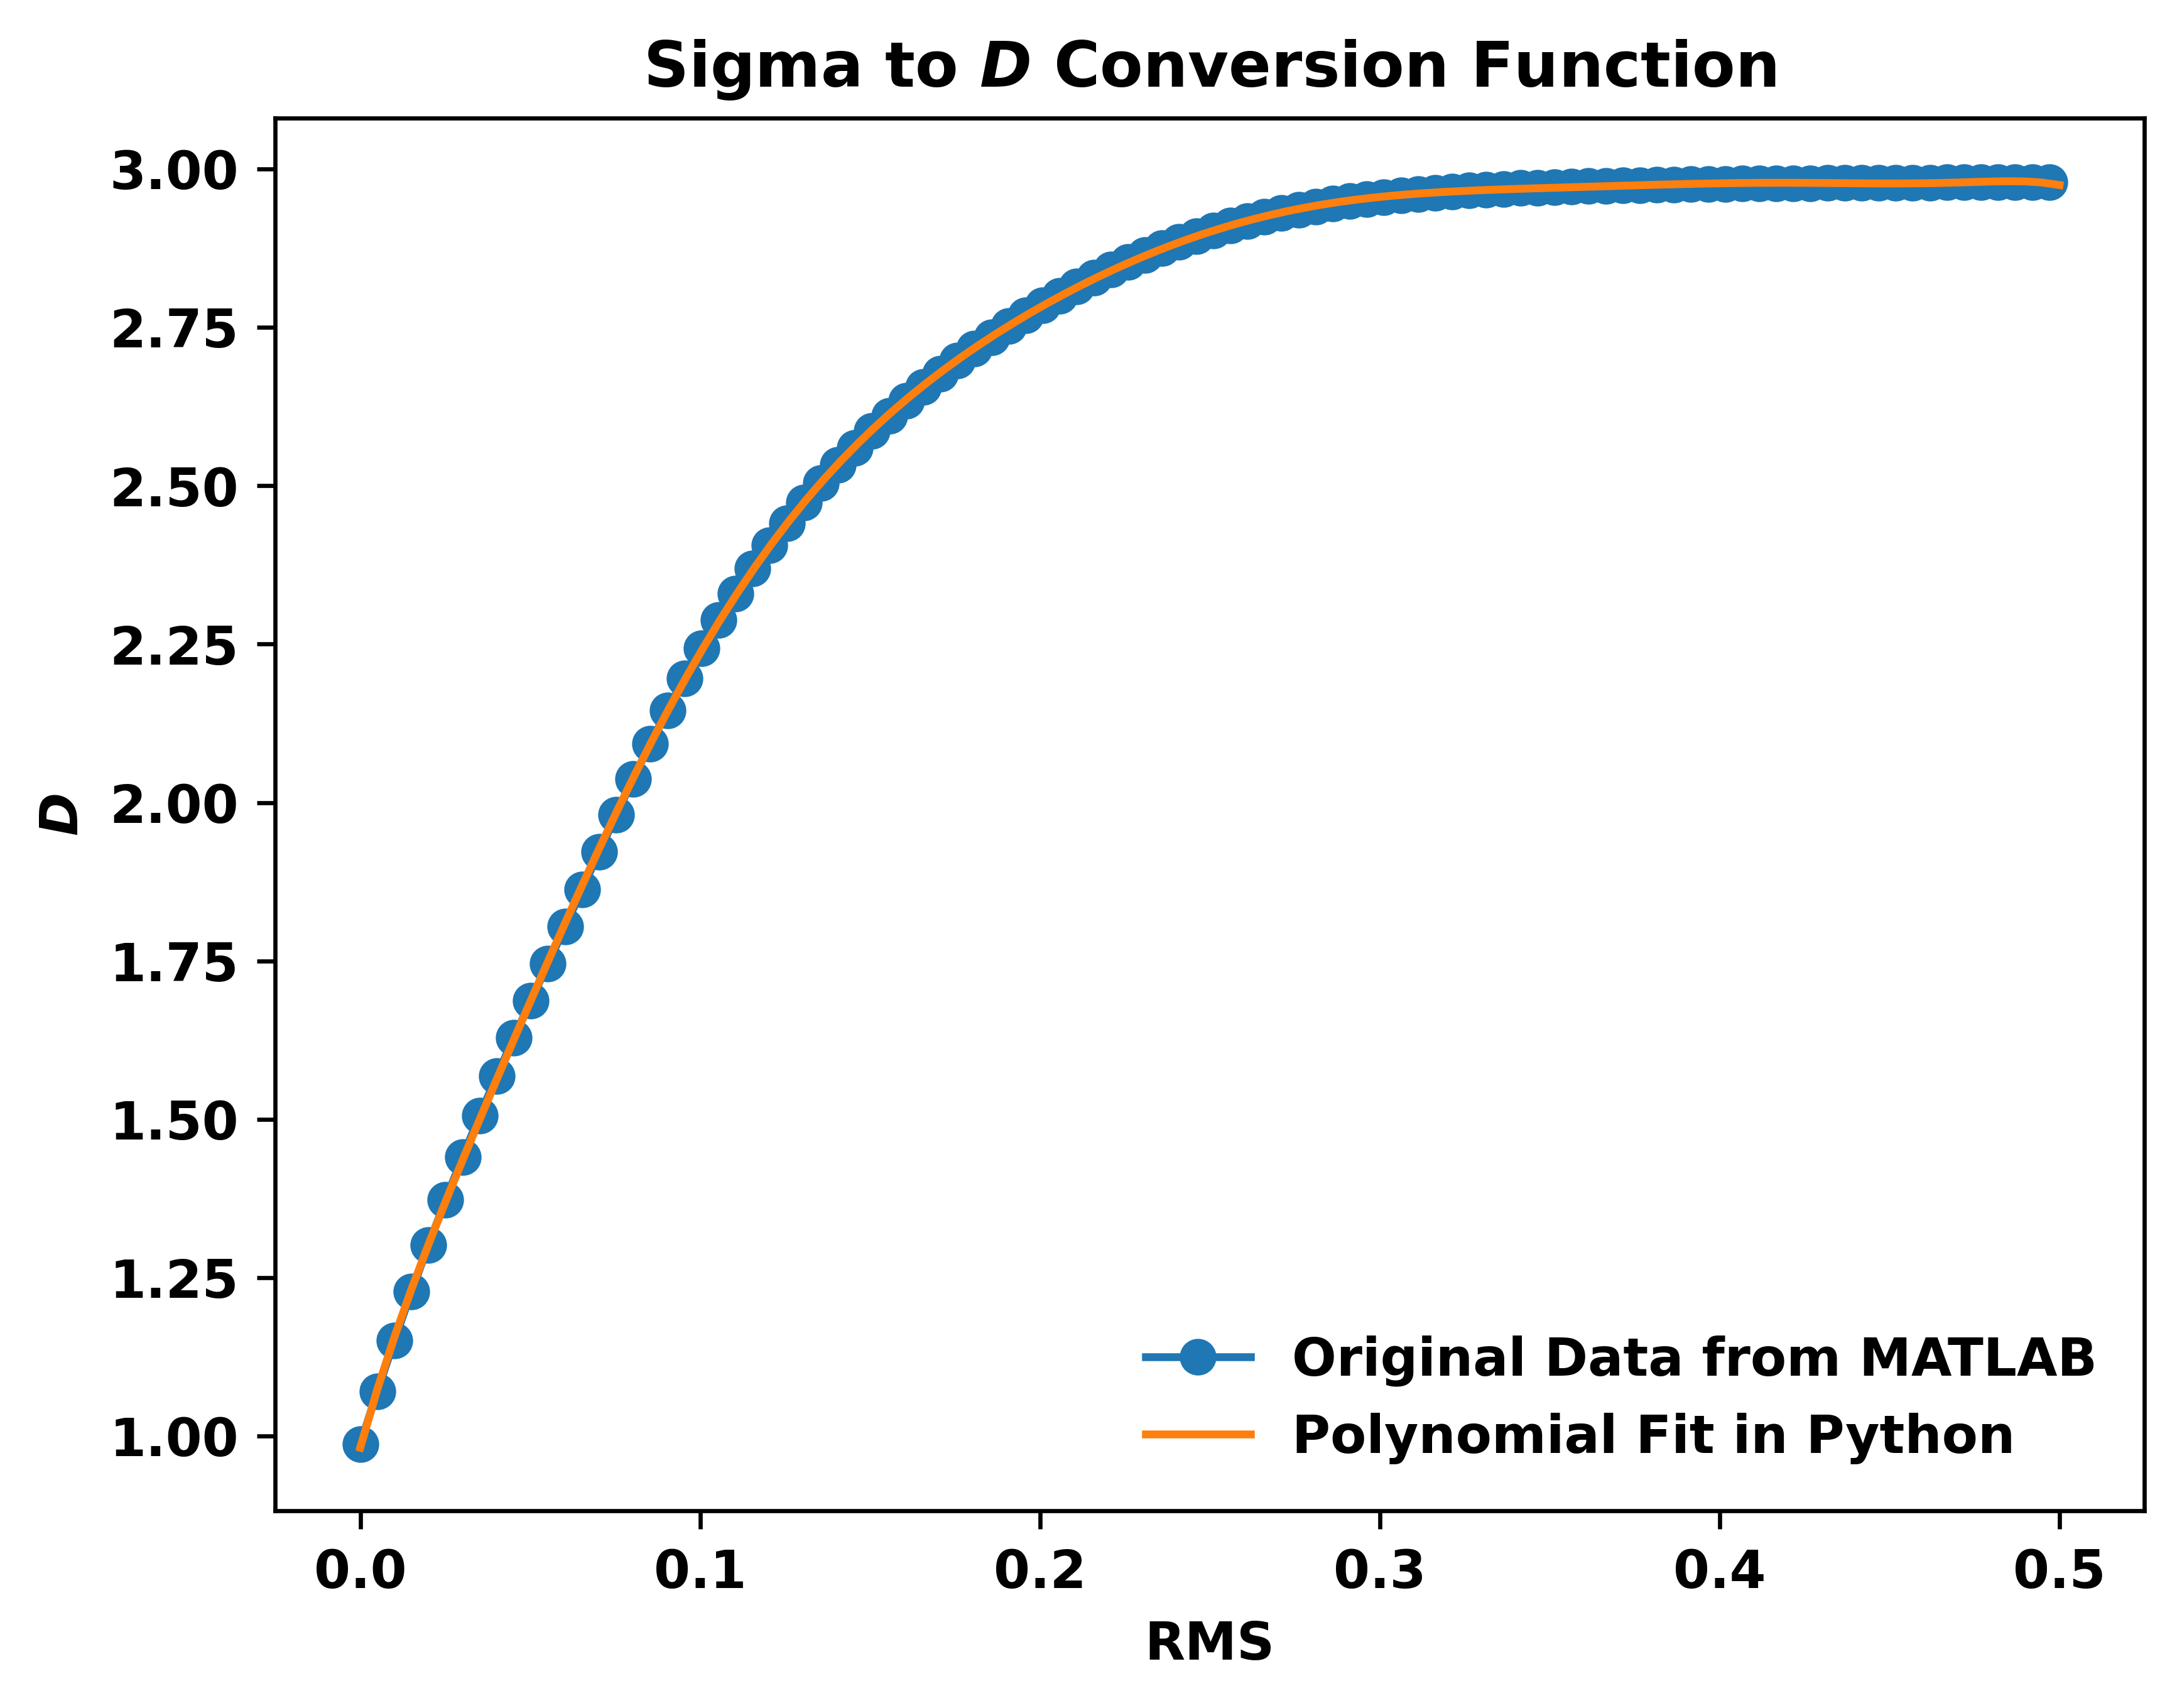

In [7]:
# Read in LUT for converting sigma to D created in MATLAB for the LCPWS1 system
convlut = pd.read_csv(conversionfolder+'\\SigmaToDLUT_LCPWS1.csv')
# Create a polynomial function from the LUT
convfunc = np.poly1d(np.polyfit(convlut.RMS,convlut.D,10))
# Create a vector of RMS values to evaluate the function
rmsvec = np.linspace(0,0.5,100)

# Plot the LUT and the function
plt.plot(convlut.RMS,convlut.D,marker='o',label='Original Data from MATLAB')
plt.plot(rmsvec,convfunc(rmsvec),label='Polynomial Fit in Python')
plt.title(r'Sigma to $D$ Conversion Function')
plt.xlabel('RMS')
plt.ylabel(r'$D$')
plt.legend()
# Save the plot to the parent folder
plt.savefig(savefolder+'\\..\\Sigma to D Conversion Function.tif',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

# Loop Through Folders to Generate PWS D Pseudocolor Images

In [8]:
# Folders with image cubes to loop through and create images
imfolders = ['\\OVCAR5 2016-12-16 Afternoon',
             '\\OVCAR3 2016-12-16 Afternoon',
             '\\OVCAR5 2017-01-20',
             '\\OVCAR5 ALDH+ 2018-01-30',
             '\\COV362 ALDH+CD133+ 2018-03-28']

# Loops through folders
for fold in imfolders:
    # Find all analyzed image cubes to create images for
    imlist = [filepath for filepath in glob.glob(pwsfolder+fold+'/**/analysisResults_p0.h5', recursive=True)]
    # Loops through image cubes
    for file in imlist:
        # Find the parent folder containing all files for the current cell
        cellfold = file.split('\\analyses')[0]
        # Get the cell number from the file path
        cellid = str.split(cellfold,'\\')[-1]
        # Path for new subfolder to save images into
        savesubfold = cellfold.split('Cubes')[1].split('\\Cell')[0]
        # New save path to subfolder
        fullsavepath = savefolder+savesubfold
        # Creates save path to subfolder if it does not exist
        if not os.path.exists(fullsavepath):
            os.makedirs(fullsavepath)
            
        # Open h5 file with the RMS image
        rmsfile = h5py.File(file, 'r')
        # Extract RMS data and multiple by LCPWS1 microscope extra reflection correction factor
        rmsim = rmsfile['rms'][()]*2.43
        # Close h5 file
        rmsfile.close()
        # Change extremely high RMS values to boundary of the conversion function
        # The conversion function does not fit the LUT well at or above RMS values of 0.5
        rmsim[rmsim>0.5] = 0.5
        # Convert the RMS image to D
        Dim = convfunc(rmsim)
        
        # Path to the ROIs in the cell folder
        roipath = cellfold+'\\ROI_nuc.h5'
        # Check if there is a file containing the ROIs
        if os.path.exists(roipath):
            # Open h5 file with the ROIs
            roifile = h5py.File(roipath, 'r')
            # Create an empty array the same shape as the image to contain the ROIs
            allrois = np.empty(Dim.shape)
            # Loop through the ROIs in the h5file
            for key in roifile.keys():
                # Extract the ROI from the h5 file
                roimask = roifile[key+'/mask'][()]
                # Add the current ROI to the ROI mask image
                allrois = allrois + roimask
            # Close the h5 file
            roifile.close()
            # Convert the ROI array to boolean type 
            allrois = allrois.astype(bool)
            # Apply the ROI mask to the D image
            maskedim = np.ma.array(Dim, mask=~allrois)
            
            # Create the red pseudocolor D image
            fig, ax = plt.subplots()
            # Display the whole image using the custom grayscale colormap
            ax.imshow(Dim, cmap=newgray, vmin=minv, vmax=maxv)
            # Display the ROIs on top of the whole image using the custom red colormap
            ax.imshow(maskedim, cmap=cmap, vmin=minv, vmax=maxv)
            # Remove the plot axes
            plt.axis('off')
            # Save the image to the specified folder
            plt.savefig(fullsavepath+'\\'+cellid+'_PWS.tif',transparent=True,bbox_inches='tight',pad_inches=0)
            plt.close(fig)
        
        # Read in the brightfield image file
        bfim = plt.imread(cellfold+'\\image_bd.tif')
        # Create the brightfield image
        fig, ax = plt.subplots()
        # Display the brightfield image using the Matplotlib grayscale colormap
        ax.imshow(bfim,cmap='gray')
        # Remove the plot axes
        plt.axis('off')
        # Save the image to the specified folder
        plt.savefig(fullsavepath+'\\'+cellid+'_BF.tif',transparent=True,bbox_inches='tight',pad_inches=0)
        plt.close(fig)
    # Display progress to user
    print('PWS Image Generation Completed for the Folder: '+fold)

PWS Image Generation Completed for the Folder: \OVCAR5 2016-12-16 Afternoon
PWS Image Generation Completed for the Folder: \OVCAR3 2016-12-16 Afternoon
PWS Image Generation Completed for the Folder: \OVCAR5 2017-01-20
PWS Image Generation Completed for the Folder: \OVCAR5 ALDH+ 2018-01-30
PWS Image Generation Completed for the Folder: \COV362 ALDH+CD133+ 2018-03-28
